In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from IPython.display import Image
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.chdir('/Users/prashant/Downloads/FaceMaskDetector/Images/dataset')
if os.path.isdir('train/with_mask/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in ['with_mask', 'without_mask']:
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 44)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
        
        test_samples = random.sample(os.listdir(f'train/{i}'), 22)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [3]:
train_path = 'Images/dataset/train'
valid_path = 'Images/dataset/valid'
test_path = 'Images/dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 308 images belonging to 2 classes.
Found 88 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [4]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [5]:
x = mobile.layers[-6].output
output = Dense(units=2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

In [6]:
# Freezing some layers
for layer in model.layers[:-23]:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [7]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
31/31 - 22s - loss: 0.1946 - accuracy: 0.9253 - val_loss: 1.2245 - val_accuracy: 0.5682
Epoch 2/30
31/31 - 20s - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.5745 - val_accuracy: 0.7500
Epoch 3/30
31/31 - 18s - loss: 0.0114 - accuracy: 0.9935 - val_loss: 0.3868 - val_accuracy: 0.8182
Epoch 4/30
31/31 - 18s - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.1915 - val_accuracy: 0.9091
Epoch 5/30
31/31 - 17s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.2095 - val_accuracy: 0.9318
Epoch 6/30
31/31 - 17s - loss: 0.0121 - accuracy: 0.9935 - val_loss: 0.0881 - val_accuracy: 0.9659
Epoch 7/30
31/31 - 17s - loss: 0.0085 - accuracy: 0.9968 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 8/30
31/31 - 17s - loss: 0.0078 - accuracy: 0.9968 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 9/30
31/31 - 17s - loss: 0.0245 - accuracy: 0.9903 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 10/30
31/31 - 17s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 11/

In [9]:
test_labels = test_batches.classes

In [10]:
predictions = model.predict(x=test_batches, verbose=0)

In [14]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
test_batches.class_indices

{'with_mask': 0, 'without_mask': 1}

In [15]:
# Extracted from Scikit learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[22  0]
 [ 0 22]]


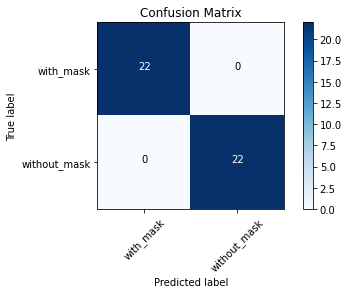

In [16]:
cm_plot_labels = ['with_mask', 'without_mask']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')